# 05 - Taming Text

In [1]:
from wordcloud import WordCloud
from nltk.corpus import stopwords, opinion_lexicon
from nltk.sentiment import *
import pandas as pd
import numpy as np
import nltk
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
%matplotlib inline

/Users/Thomas/anaconda/lib/python3.5/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
# import data
directory = 'hillary-clinton-emails/'
aliases = pd.read_csv(directory+'aliases.csv')
email_receivers = pd.read_csv(directory+'EmailReceivers.csv')
emails = pd.read_csv(directory+'Emails.csv')
persons = pd.read_csv(directory+'Persons.csv')

### Comparison between extracted body text and raw text

In [3]:
i = 2
print(emails['ExtractedBodyText'][i], '\n\n END OF BODY TEXT \n\n', emails['RawText'][i])


Thx 

 END OF BODY TEXT 

 UNCLASSIFIED
U.S. Department of State
Case No. F-2015-04841
Doc No. C05739547
Date: 05/14/2015
STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.
SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.
RELEASE IN
PART B6
From: Mills, Cheryl D <MillsCD@state.gov>
Sent: Wednesday, September 12, 2012 11:52 AM
To: B6
Cc: Abedin, Huma
Subject: Re: Chris Stevens
Thx
Original Message
From: Anne-Marie Slaughter [
Sent: Wednesday, September 12, 2012 07:46 AM
To: Ihdr22@clintonernail.com' <hdr22@clintonemail corn>
Cc: Abed in, Huma; Mills, Cheryl D
Subject: Chris Stevens
To you and all my former colleagues, I'm so terribly sorry. Our FSOs stand on the front lines just as surely and devotedly
as our soldiers do. Thinking of you and Pat and everyone this morning.
AM
UNCLASSIFIED
U.S. Department of State
Case No. F-2015-04841
Doc No. C05739547
Date: 05/14/2015
STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.
SUBJECT TO AGREEMENT ON SENSITIVE IN

By reading a few emails we can see that the extracted body text is just the text that the email sender wrote (as stated on Kaggle) while the raw text gathers the previous emails forwarded or the whole discussion. Note that the extracted body text can sometimes contain NaNs. By including repeated messages in the raw text, you induce bias in the distribution of the words, thus we kept only the body text

## 1. Worldclouds

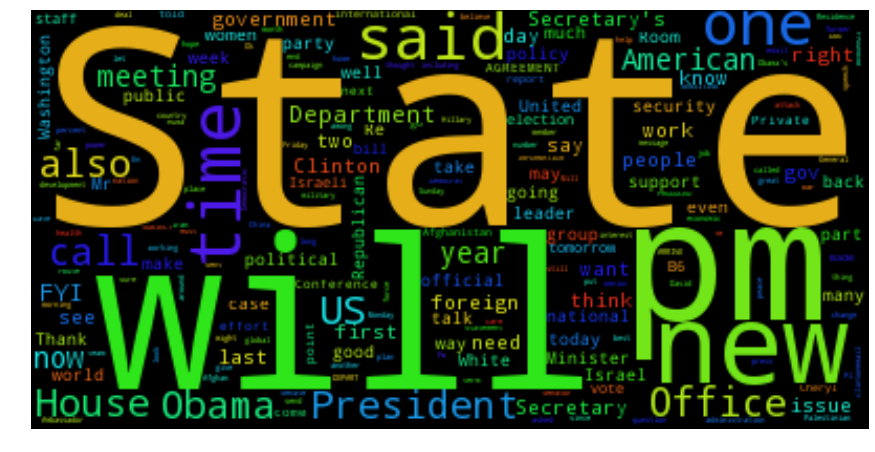

In [4]:
# raw corpus
text_corpus = emails.ExtractedBodyText.dropna().values
raw_text = ' '.join(text_corpus)

# generate wordcloud
wordcloud = WordCloud().generate(raw_text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.axis('off');

In [44]:
def preprocess(text, stemmer):
    print('Length of raw text: ', len(raw_text))
    
    # tokenization (need to install models/punk from nltk.download())
    tokens = nltk.word_tokenize(raw_text, language='english')
    print('Number of tokens extracted: ', len(tokens))
    
    # stopwords removal (need to install stopwords corpus in corpora/stopwords)
    # cach stopwords to improve performance (70x speedup)
    cached_stopwords = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in cached_stopwords]
    print('Number of tokens after stopword removal: ', len(filtered_tokens))
    
    # stemming
    if stemmer == 'snowball':
        stemmer = nltk.SnowballStemmer('english')
    elif stemmer == 'porter':
        stemmer = nltk.PorterStemmer('english')
    else: 
        print('choose appropriate stemmer')
    stemmed_filtered_tokens = [stemmer.stem(t) for t in filtered_tokens]
    
    # dump array in text file
    output = ' '.join(stemmed_filtered_tokens)
    return output
        

Length of raw text:  3601322
Number of tokens extracted:  697009
Number of tokens after stopword removal:  475544


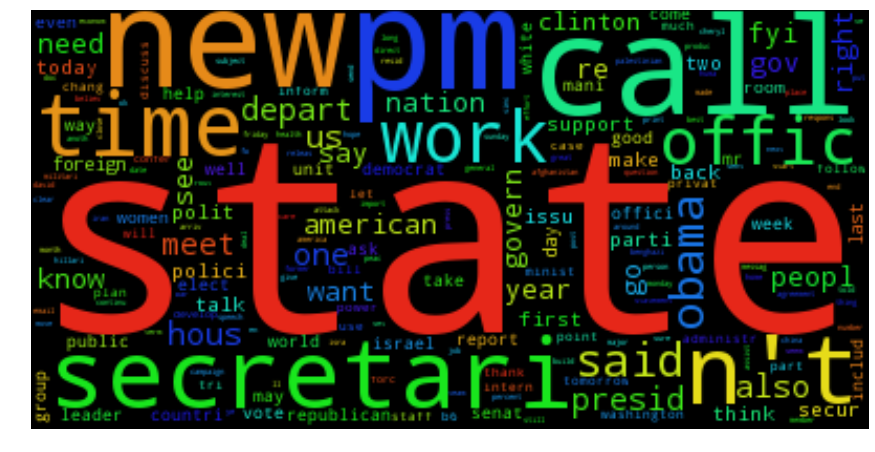

In [45]:
preprocessed_text = preprocess(raw_text, 'snowball')
wordcloud2 = WordCloud().generate(preprocessed_text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud2)
plt.axis('off');

## Comparison between the word clouds

Looking at the wordcloud generated after having preprocessed the data, it seems that stemming hurt the "performance" of the wordcloud, indeed a number of words have been incorrectly stemmed e.g. department has been reduced to depart, secretary to secretary, message to messag and so on. Also the distribution of the words are not the same, obviously.

## 2. Sentiment analysis
from [this link](https://www.kaggle.com/ampaho/d/kaggle/hillary-clinton-emails/foreign-policy-map-through-hrc-s-emails/code),we added the following words to be removed from the emails:
* add "RE" because the iso3 code for Reunion islands.. but it appears a lot in emails to indicate the RE(sponses) to previous emails.
* FM
* TV is ISO2 code for Tuvalu but also refers to Television
* AL is a given name and also ISO2 for Albania
* BEN is a given name and also ISO3 for Benin
* LA is Los angeles and iso 2 for Lao
* AQ is abbreviation of "As Quoted" and iso 2 for Antarctica

After a few runs, we looked at the (unusual) countries extracted. For example the country Saint Pierre and Miquelon is mentionned 631 times, not bad for such a small country. We noticed that an important number of emails have words capitalized and are misinterpreted as ISO2/ISO3 codes for countries. To cope with this we added the following stop words:
* AND is ISO3 for Andorra
* AM is ISO2 for Armenia
* AT is ISO2 for Austria
* IN is ISO2 for India
* NO is ISO2 for Norway
* PM is iSO2 for Saint Pierre and Miquelon
* TO is ISO2 for Tonga
* BY is ISO2 for Belarus
* IE is ISO2 for Ireland (id est)
* IT is ISO2 for Italy
* MS is ISO2 for Montserrat

In [6]:
country_objects = list(pycountry.countries)
country_names = []
country_ISO2s = []
country_ISO3s = []
for country in country_objects:
    country_names.append(country.name)
    country_ISO2s.append(country.alpha_2)
    country_ISO3s.append(country.alpha_3)

In [7]:
def find_countries(tokens, country_names=country_names, country_ISO2s=country_ISO2s, country_ISO3s=country_ISO3s):
    upper_tokens = ' '.join(tokens).title().split()
    countries_by_name = set.intersection(set(upper_tokens), set(country_names))
    countries_by_ISO2 = set.intersection(set(tokens), set(country_ISO2s))
    countries_by_ISO3 = set.intersection(set(tokens), set(country_ISO3s))
    for ISO2 in countries_by_ISO2:
        countries_by_name.add(pycountry.countries.get(alpha_2=ISO2).name)
    for ISO3 in countries_by_ISO3:
        countries_by_name.add(pycountry.countries.get(alpha_3=ISO3).name)
    return countries_by_name

In [34]:
def foreign_policy(emails, sentiment_analyzer):
    start_time = time.time()
    words_to_be_removed = ["RE", "FM", "TV", "LA", "AL", "BEN", "AQ", "AND", "AM", "AT", "IN", "NO", "PM", "TO",
                          "BY", "IE", "IT", "MS"]
    vader_analyzer = SentimentIntensityAnalyzer()
    foreign_policy = {}
    cached_stopwords = set(stopwords.words('english'))
    cached_stopwords.update(words_to_be_removed)
    i=0
    score = 0
    for email in emails: 
        #print('{:d} / {:d} emails processed'.format(i, len(emails)))
        tokens = nltk.word_tokenize(email, language='english')
        tokens = [word for word in tokens if word not in cached_stopwords]
        # country lookup in tokens
        countries = find_countries(set(tokens))
        i +=1
        if not countries: continue
        
        if sentiment_analyzer =='vader':
            sentiment = vader_analyzer.polarity_scores(email)
            score = sentiment['compound']
        elif sentiment_analyzer =='liu_hu':
                    score = score + len(set.intersection(set(tokens), set(opinion_lexicon.positive()))) \
                                        - len(set.intersection(set(tokens), set(opinion_lexicon.negative())))
        else: print("Choose vader or liu_hu as analyzer")
        for country in countries:
            if not country in foreign_policy.keys():
                foreign_policy.update({country: [score, 1]})
            else:
                foreign_policy[country][0] += score
                foreign_policy[country][1] += 1
    for country, value in foreign_policy.items():
        foreign_policy.update({country: [(value[0]/value[1]), value[1]]})
    print("--- %d seconds elapsed ---" % (time.time() - start_time))
    return foreign_policy

In [11]:
result = foreign_policy(text_corpus, sentiment_analyzer='vader')

--- 969 seconds elapsed ---


In [12]:
def create_palette(sentiments):
    color_palette = []
    minimum = np.min(sentiments)
    maximum = np.max(sentiments)
    for sentiment in sentiments:
        rescaled = (sentiment-minimum) / (maximum - minimum)
        g = rescaled
        r = 1 - g
        color_palette.append((r,g,0))
    return color_palette

### Plotting the foreign policy

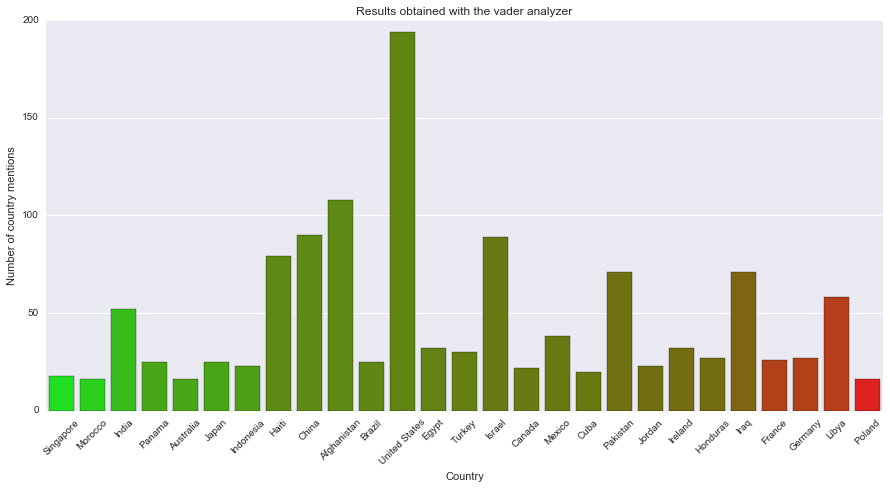

In [41]:
df = pd.DataFrame.from_dict(result, orient='index')
df.reset_index(inplace=True)
df.columns =['Country', 'Sentiment', 'Count']
df = df[df['Count'] > 15]
df = df.sort_values('Sentiment', ascending=False)
gradient = create_palette(df['Sentiment'].values)
plt.figure(figsize=(15,7))
plot = sns.barplot(x='Country', y='Count', data=df, orient='vertical', palette=gradient)
plt.xticks(rotation=45);
plt.ylabel('Number of country mentions')
plt.title('Results obtained with the vader analyzer');

On the above plot we see each country that appears more than 15 times, ordered and colored by sentiment

In [35]:
result2 = foreign_policy(text_corpus, sentiment_analyzer='liu_hu')

--- 37 seconds elapsed ---


### Plot using Liu Hu lexicon sentiment analysis

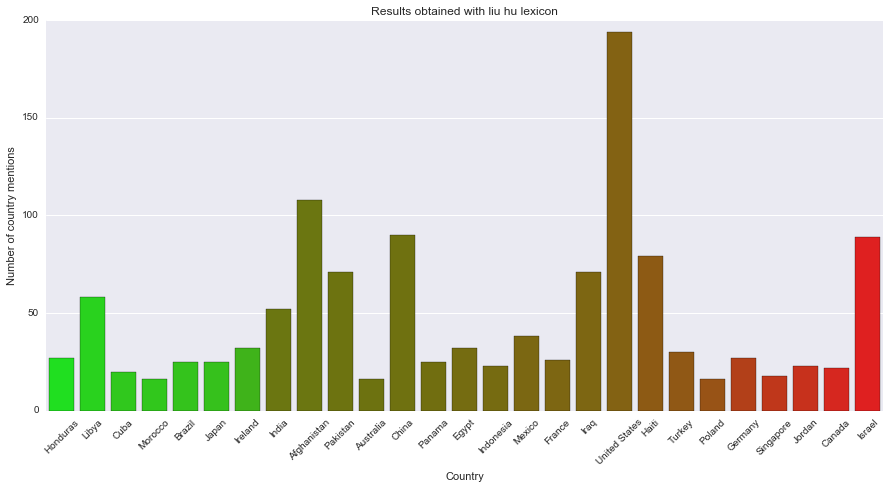

In [43]:
df = pd.DataFrame.from_dict(result2, orient='index')
df.reset_index(inplace=True)
df.columns =['Country', 'Sentiment', 'Count']
df = df[df['Count'] > 15]
df = df.sort_values('Sentiment', ascending=False)
gradient = create_palette(df['Sentiment'].values)
plt.figure(figsize=(15,7))
plot = sns.barplot(x='Country', y='Count', data=df, orient='vertical', palette=gradient)
plt.xticks(rotation=45);
plt.ylabel('Number of country mentions')
plt.title('Results obtained with liu hu lexicon');

### Some observations:
There is a lot of difference between the vader analyzer and the Liu Hu method, for example Singapore is the most positive country with vader while it is one of the "worst" countries with the Liu Hu method. This can be explained by the fact that we didn't take into account any neutral word when we computed the score with the Liu hu method, the "compound" metric returned by vader is already normalized with respect to the number of words and their respective sentiment in the email to be analyzed.